In [ ]:
import numpy as np # linear algebra
import pandas as pd 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem75.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem340.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem2422.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem77.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem480.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem540.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem794.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem608.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem335.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train/NonDemented/nonDem3.jpg
/content/drive/MyDrive/Colab Notebooks/Alzheimers_Da

#Import Libraries

In [ ]:
# necessary libraries
import os
import pandas as pd

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

#Explore dataset

In [ ]:
base_dir= "/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset"
os.listdir(base_dir)

['test', 'train', 'single_prediction']

#Generating Train and Validation set using Data Augmentation 

In [ ]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train', 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Alzheimers_Dataset/train', 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 4097 images belonging to 2 classes.

validation data :
Found 1024 images belonging to 2 classes.


Class Labels

In [ ]:
train_data.class_indices

{'Demented': 0, 'NonDemented': 1}

#Model Building

Transfer Learning - Inception V3 Model

In [ ]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception_model= InceptionV3(input_shape= (300, 300,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception_model.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
pretrained_model= Model(inception_model.input, last_output)  

87924736/87910968 [==============================] - 1s 0us/step


Creating Dense Layers

In [ ]:
# layer 1
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
model= Model(pretrained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

#Training the CNN

In [ ]:
# compile model
from tensorflow import keras
from tensorflow.keras import optimizers
# optimizer=keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again. 
# So we will freeze these layers
for layer in pretrained_model.layers:
    layer.trainable= False

# model fitting
history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=2 
                  )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
204/204 - 690s - loss: 0.8701 - accuracy: 0.5806 - val_loss: 0.8740 - val_accuracy: 0.6892 - 690s/epoch - 3s/step
Epoch 2/10
204/204 - 236s - loss: 0.5907 - accuracy: 0.6865 - val_loss: 0.8069 - val_accuracy: 0.5814 - 236s/epoch - 1s/step
Epoch 3/10
204/204 - 236s - loss: 0.5628 - accuracy: 0.7093 - val_loss: 0.4706 - val_accuracy: 0.7706 - 236s/epoch - 1s/step
Epoch 4/10
204/204 - 236s - loss: 0.5226 - accuracy: 0.7439 - val_loss: 0.9145 - val_accuracy: 0.6775 - 236s/epoch - 1s/step
Epoch 5/10
204/204 - 236s - loss: 0.4711 - accuracy: 0.7773 - val_loss: 0.6752 - val_accuracy: 0.7971 - 236s/epoch - 1s/step
Epoch 6/10
204/204 - 236s - loss: 0.4249 - accuracy: 0.8048 - val_loss: 1.2329 - val_accuracy: 0.7363 - 236s/epoch - 1s/step
Epoch 7/10
204/204 - 235s - loss: 0.4007 - accuracy: 0.8271 - val_loss: 0.7409 - val_accuracy: 0.7814 - 235s/epoch - 1s/step
Epoch 8/10
204/204 - 236s - loss: 0.3611 - accuracy: 0.8553 - val_loss: 0.5790 - val_accuracy: 0.8000 - 236s/epoch - 1s/step


#Model Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

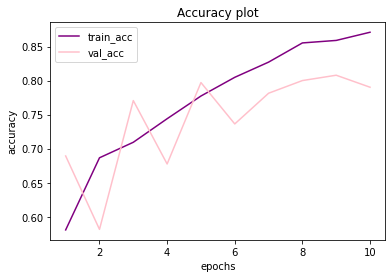

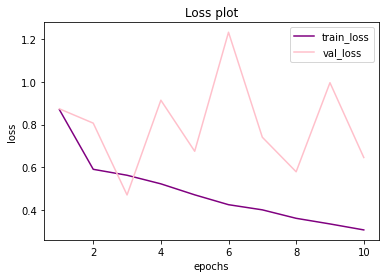

In [ ]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

#Checking model performance

In [ ]:
import numpy as np

prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= (prediction > 0.5)
prediction

52/52 - 34s - 34s/epoch - 648ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

#Confusion matrix

0.7900390625
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       512
           1       0.85      0.71      0.77       512

    accuracy                           0.79      1024
   macro avg       0.80      0.79      0.79      1024
weighted avg       0.80      0.79      0.79      1024



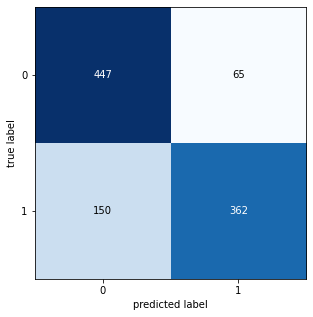

In [ ]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Alzheimers_ridhi2.h5")